[*********************100%***********************]  3 of 3 completed


TSLA lagged data shape: (2482, 5)
BND lagged data shape: (2482, 5)
SPY lagged data shape: (2482, 5)
Shape of combined data after concatenation: (2482, 15)
Combined Data Index:
DatetimeIndex(['2015-01-12 00:00:00+00:00', '2015-01-13 00:00:00+00:00',
               '2015-01-14 00:00:00+00:00', '2015-01-15 00:00:00+00:00',
               '2015-01-16 00:00:00+00:00', '2015-01-20 00:00:00+00:00',
               '2015-01-21 00:00:00+00:00', '2015-01-22 00:00:00+00:00',
               '2015-01-23 00:00:00+00:00', '2015-01-26 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', freq=None)
Target Index:
DatetimeIndex(['2015-01-05 00:00:00+00:00', '2015-01-06 00:00:00+00:00',
               '2015-01-07 00:00:00+00:00', '2015-01-08 00:00:00+00:00',
               '2015-01-09 00:00:00+00:00', '2015-01-12 00:00:00+00:00',
               '2015-01-13 00:00:00+00:00', '2015-01-14 00:00:00+00:00',
               '2015-01-15 00:00:00+00:00', '2015-01-16 00:00:00+00:00'],
           

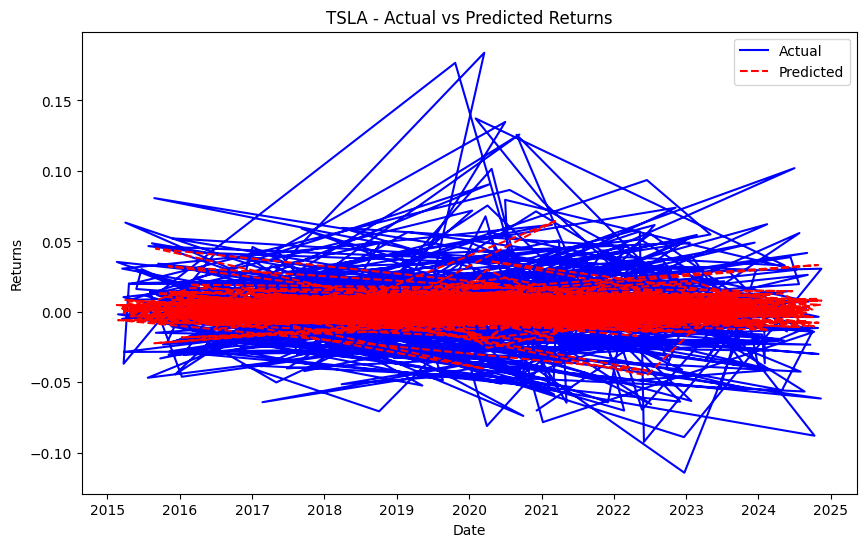

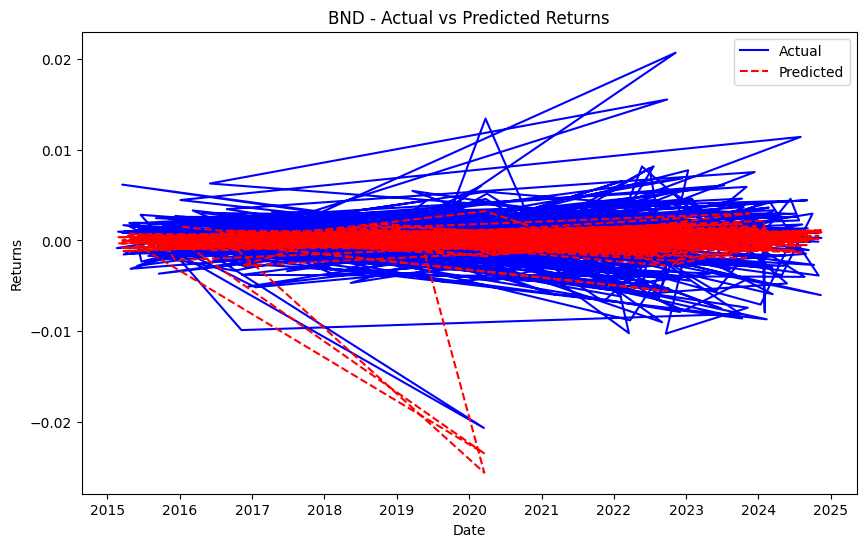

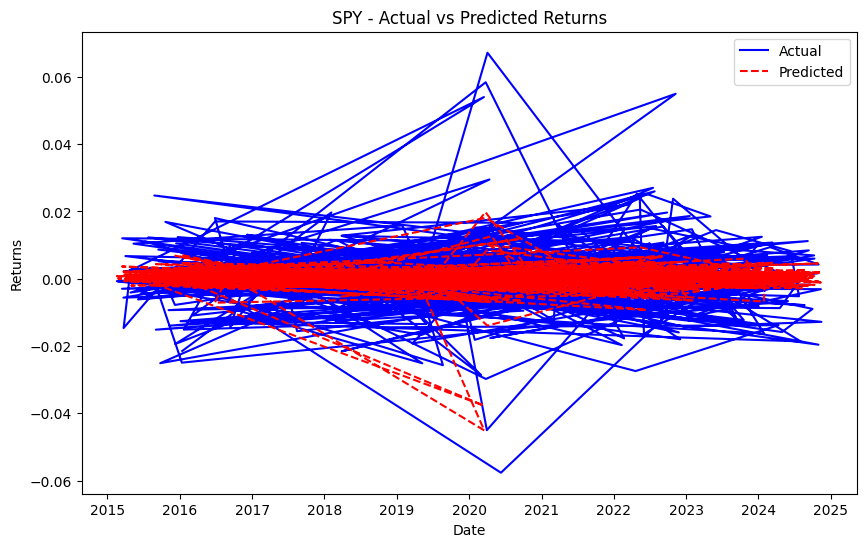


Next Day Predictions (Returns):
TSLA: -0.0020
BND: -0.0003
SPY: 0.0017


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Fetch historical data for TSLA, BND, and SPY
tickers = ['TSLA', 'BND', 'SPY']
data = yf.download(tickers, start='2015-01-01', end='2024-12-31')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Create lagged features (past returns) for predictive modeling
def create_lagged_features(data, lags=5):
    lagged_data = pd.DataFrame()
    for lag in range(1, lags + 1):
        lagged_data[f'Lag_{lag}'] = data.shift(lag)
    lagged_data.dropna(inplace=True)  
    return lagged_data

# Create lagged features for all assets
lagged_data = {}
for ticker in tickers:
    lagged_data[ticker] = create_lagged_features(returns[ticker], lags=5)

# Check the shape of lagged_data for each ticker
for ticker in tickers:
    print(f"{ticker} lagged data shape: {lagged_data[ticker].shape}")

# Combine the lagged data for all assets into one DataFrame
combined_data = pd.concat(lagged_data.values(), axis=1)

# Check the number of columns after concatenation
print(f"Shape of combined data after concatenation: {combined_data.shape}")

# Generate the correct column names based on the number of assets and lags
combined_data.columns = [f'{ticker}_Lag_{i}' for ticker in tickers for i in range(1, 6)]

# Set the target variable as the next day's return (or price change)
target = pd.DataFrame({
    ticker: returns[ticker].shift(-1) for ticker in tickers
})
target = target.dropna()

# Inspect the indices of both dataframes
print("Combined Data Index:")
print(combined_data.index[:10])  

print("Target Index:")
print(target.index[:10])  

# After dropping NaN values from the target, re-align combined_data's index
combined_data = combined_data.loc[combined_data.index.isin(target.index)]

# Verify the indices are aligned now
print("Combined Data Index after alignment:")
print(combined_data.index[:10])

print("Target Index after alignment:")
print(target.index[:10])

# Combine features and target into one DataFrame
model_data = combined_data.join(target)

# Continue with the rest of the processing
X = model_data.iloc[:, :-len(tickers)]  
y = model_data.iloc[:, -len(tickers):]  

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (important for many machine learning models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for each asset
models = {}
predictions = {}
for ticker in tickers:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train[ticker])  # Fit on non-NaN y_train
    models[ticker] = model
    predictions[ticker] = model.predict(X_test_scaled)

# Evaluate the models using MAE, RMSE, and R²
evaluation_metrics = {}
for ticker in tickers:
    y_pred = predictions[ticker]
    y_true = y_test[ticker]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    evaluation_metrics[ticker] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }

# Print evaluation metrics for each model
print("Evaluation Metrics (MAE, RMSE, R²) for each asset:")
for ticker in tickers:
    print(f"{ticker}: {evaluation_metrics[ticker]}")

# Visualizing Predictions vs Actual Values
def plot_predictions(ticker):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test[ticker], label='Actual', color='blue')
    plt.plot(y_test.index, predictions[ticker], label='Predicted', color='red', linestyle='--')
    plt.title(f"{ticker} - Actual vs Predicted Returns")
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Plot predictions for each asset
for ticker in tickers:
    plot_predictions(ticker)

# Predict the next day's return (or price change) for each asset
next_day_predictions = {}
for ticker in tickers:
    # Use the last row from the test set to predict the next day's return
    next_day_return = models[ticker].predict(X_test_scaled[-1].reshape(1, -1))  
    next_day_predictions[ticker] = next_day_return[0]

# Print next day's predicted returns
print("\nNext Day Predictions (Returns):")
for ticker in tickers:
    print(f"{ticker}: {next_day_predictions[ticker]:.4f}")
